# Sprint 1: Data analysis and supervised learning

Tijdens deze eerste sprint wordt enkel gefocust op het classificeren op basis van de verschillende product en issue categorieën. In de volgende sprints zullen ook de classificatie van sub-producten en sub-issues aan bod komen.

## Exploratory Data Analysis

Inlezen van het CSV bestand naar een DataFrame.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re, string

rows_to_read = 5000 # Gewenst aantal rijen inlezen (None = allemaal)

complaints = pd.read_csv('data/complaints.csv', delimiter=',', nrows=rows_to_read)

rows, cols = complaints.shape

print(f'Er zijn {rows} rijen en {cols} kolommen')

Er zijn 5000 rijen en 18 kolommen


Om een overzicht te krijgen van de gebruikte kolommen en de hoeveelheid data, maken we hier gebruik van de info() methode.

In [29]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 5000 non-null   object
 1   Product                       5000 non-null   object
 2   Sub-product                   5000 non-null   object
 3   Issue                         5000 non-null   object
 4   Sub-issue                     5000 non-null   object
 5   Consumer complaint narrative  5000 non-null   object
 6   Company public response       5000 non-null   object
 7   Company                       5000 non-null   object
 8   State                         5000 non-null   object
 9   ZIP code                      5000 non-null   object
 10  Tags                          5000 non-null   object
 11  Consumer consent provided?    5000 non-null   object
 12  Submitted via                 5000 non-null   object
 13  Date sent to compa

De Dataframe aanpassen naar de belangrijkste kolommen.
- Product
- Sub-product
- Issue
- Sub-issue
- Consumer complaint narrative

In [30]:
complaints_df = complaints[['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative']].copy()

# Kolommen een simpelere naam geven
complaints_df.columns = ['Product', 'Sub_Product', 'Issue', 'Sub_Issue', 'Narrative'] 
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative
0,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...
4,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...


### Aantal klachten per categorie van producten

In [31]:
complaints_df.Product.unique()

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Payday loan, title loan, or personal loan',
       'Mortgage', 'Credit card or prepaid card',
       'Checking or savings account', 'Student loan',
       'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service',
       'Credit card'], dtype=object)


Er zijn meer dan 10 verschillende categorieën voor de producten. Sommige zijn echter heel erg gerelateerd aan elkaar. Daarom kan het nuttig zijn om sommige categorieën samen te nemen om de accuraatheid van het te bekomen model te verbeteren.
- 'Credit reporting, repair, or other'
    - 'Credit reporting, credit repair services, or other personal consumer reports'
    - 'Credit reporting'
- 'Credit card or prepaid card'
    - 'Credit card'
    - 'Prepaid card'
- 'Payday loan, title loan, or personal loan
    - 'Payday loan'
- 'Money transfer, virtual currency, or money service'
    - 'Money transfer' 
    - 'Virtual currency'

In [32]:
complaints_df.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

Er blijven nu slechts 8 product categorieën over.

In [33]:
complaints_df.Product.unique()

array(['Credit reporting, repair, or other', 'Debt collection',
       'Payday loan, title loan, or personal loan', 'Mortgage',
       'Credit card or prepaid card', 'Checking or savings account',
       'Student loan', 'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service'], dtype=object)

Er blijven nu slechts 13 product categorieën over.

Om het mogelijk te maken om een model te ontwikkelen gaan we elke categorie die in tekstvorm in de dataset staat, gaan voorstellen als een getal. Hiervoor voegen we een nieuwe kolom toe met als naam 'Category_Id'.

In [34]:
complaints_df['Category_Id'] = complaints_df['Product'].factorize()[0]

# Dictionary aanmaken die de 'Category_Id - Product' combinaties bevat
categories = dict(complaints_df[['Category_Id', 'Product']].drop_duplicates().values)
categories

{0: 'Credit reporting, repair, or other',
 1: 'Debt collection',
 2: 'Payday loan, title loan, or personal loan',
 3: 'Mortgage',
 4: 'Credit card or prepaid card',
 5: 'Checking or savings account',
 6: 'Student loan',
 7: 'Vehicle loan or lease',
 8: 'Money transfer, virtual currency, or money service'}

In [35]:
# Nieuwe DataFrame met de extra kolom weergeven
complaints_df.head()

,Product,Sub_Product,Issue,Sub_Issue,Narrative,Category_Id
0,"Credit reporting, repair, or other",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,0
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...,1
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...,1
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...,1
4,"Credit reporting, repair, or other",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...,0


Vervolgens gaan we het aantal complaints per product tellen.

In [36]:
# Aantal products
product_counts = pd.DataFrame({'Count': complaints_df.groupby(['Product']).size()})
product_counts

,Count
Product,
Checking or savings account,261
Credit card or prepaid card,447
"Credit reporting, repair, or other",2410
Debt collection,1026
"Money transfer, virtual currency, or money service",108
Mortgage,407
"Payday loan, title loan, or personal loan",78
Student loan,139
Vehicle loan or lease,124


<Figure size 720x360 with 0 Axes>

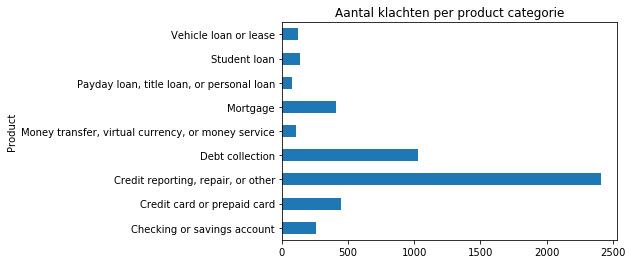

In [37]:
fig = plt.figure(figsize=(10, 5))
product_counts.plot.barh(title="Aantal klachten per product categorie", legend=None)

De verdeling van de data over de verschillende categorieën is niet gebalanceerd. Dit kan voor problemen zorgen bij het classificeren aangezien de kleine categorieën als uitschieters gezien kunnen worden. We zouden deze categorieën kunnen oversampelen zodat de dataset gebalanceerd wordt, maar aangezien de categorieën die het meest voorkomen ook het meest waarschijnlijk voorkomen tijdens het classificeren, zullen we dit niet doen.

Om deze categorieën van producten en sub-producten beter te begrijpen, gaan we het verband tussen beiden gaan onderzoeken.

In [38]:
sub_product_counts = pd.DataFrame({'Count': complaints_df.groupby(['Product', 'Sub_Product']).size()})
sub_product_counts.head(10)

Count
Product                     Sub_Product                                      
Checking or savings account CD (Certificate of Deposit)                     1
                            Checking account                              216
                            Other banking product or service               21
                            Savings account                                23
Credit card or prepaid card General-purpose credit card or charge card    353
                            General-purpose prepaid card                   21
                            Gift card                                       2
                            Government benefit card                         4
                            None                                            1
                            Payroll card                                    2

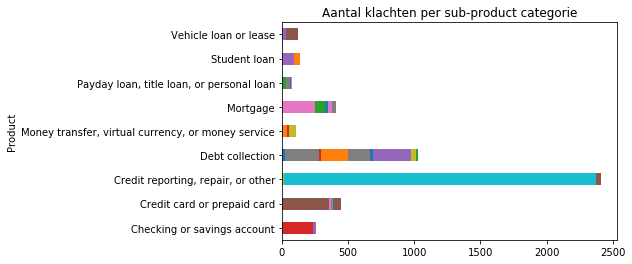

In [39]:
sub_product_counts.unstack().plot(kind='barh', stacked=True, legend=None, title="Aantal klachten per sub-product categorie")

### Aantal klachten per categorie van issues

Hieronder worden het aantal complaints per issue geteld en worden de distributies van de sub-issues getoond.

In [40]:
issue_counts = complaints_df.groupby('Issue')['Issue'].count()
issue_counts.sort_values(ascending=False)

Issue
Incorrect information on your report                                                1362
Problem with a credit reporting company's investigation into an existing problem     685
Attempts to collect debt not owed                                                    452
Improper use of your report                                                          260
Trouble during payment process                                                       197
                                                                                    ... 
Cont'd attempts collect debt not owed                                                  1
Vehicle was damaged or destroyed the vehicle                                           1
Credit line increase/decrease                                                          1
Was approved for a loan, but didn't receive money                                      1
Problem with additional add-on products or services                                    1
Name: Issue, Le

In [41]:
subissue_counts = pd.DataFrame({'Count': complaints_df.groupby(['Issue', 'Sub_Issue'])['Sub_Issue'].count()})
subissue_counts.sort_values(by=['Issue','Count'],ascending=[True,False])

Count
Issue                                              Sub_Issue                                                
Advertising                                        Changes in terms from what was offered or adver...      1
                                                   Confusing or misleading advertising about the card      1
Advertising and marketing, including promotiona... Confusing or misleading advertising about the c...     17
                                                   Didn't receive advertised or promotional terms         16
Applying for a mortgage                            None                                                    2
...                                                                                                      ...
Was approved for a loan, but didn't receive money  None                                                    1
Written notification about debt                    Didn't receive enough information to verify debt      120
                                                   Didn't receive notice of right to dispute              57
                                                   Notification didn't disclose it was an attempt ...      7
Wrong amount charged or received                   None                                                    3

[192 rows x 1 columns]

Voor een duidelijker overzicht worden de 20 meest voorkomende issues geplot in een histogram.

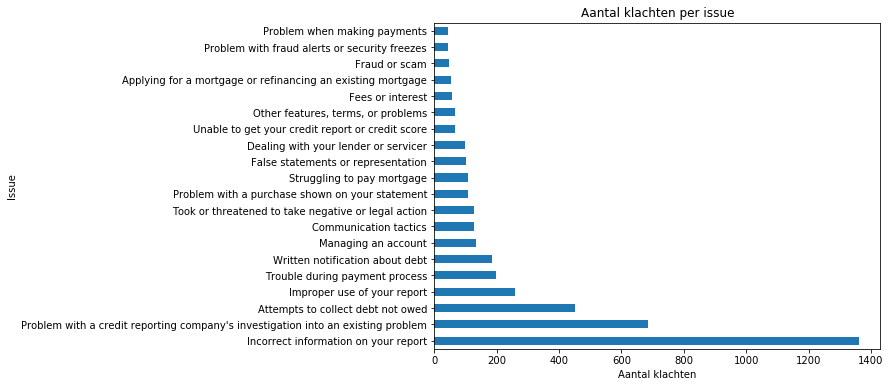

In [42]:
fig = plt.figure(figsize=(8,6))
issue_counts.sort_values(ascending=False).head(20).plot.barh(ylim=0, title="Aantal klachten per issue")
plt.xlabel('Aantal klachten', fontsize = 10);

Zoals je ziet zijn er veel verschillende issues (161) en is de data ongebalanceerd. Daarom zullen we enkel de 20 meest voorkomende issues gebruiken om het model te trainen. Dit is namelijk 87% van alle data. Hier worden ze nog eens getoond.

In [43]:
som = 0
for aantal in issue_counts.sort_values(ascending=False).head(20):
    som += aantal
print('Percentage: ' + str(round(som/len(complaints_df.index)*100)) + '%')
issue_counts.sort_values(ascending=False).head(20)

Percentage: 87%


Issue
Incorrect information on your report                                                1362
Problem with a credit reporting company's investigation into an existing problem     685
Attempts to collect debt not owed                                                    452
Improper use of your report                                                          260
Trouble during payment process                                                       197
Written notification about debt                                                      184
Managing an account                                                                  135
Communication tactics                                                                127
Took or threatened to take negative or legal action                                  127
Problem with a purchase shown on your statement                                      109
Struggling to pay mortgage                                                           108
False statement

Wat opvalt is dat sommige categorieën een andere naam krijgen maar dat de data eigenlijk onder dezelfde categorie zou mogen geplaatst worden. Dit is bijvoorbeeld het geval bij 'Attempts to collect debt not owed' en 'Cont'd attempts collect debt not owed'. Daarom zullen we deze kolommen samen nemen onder dezelfde noemer.

In [44]:
complaints_df.replace({'Issue': 
            {'Cont\'d attempts collect debt not owed':'Attempts to collect debt not owed',
            'Dealing with my lender or servicer':'Dealing with your lender or servicer'}}, 
            inplace= True)
issue_counts = complaints_df.groupby('Issue')['Issue'].count()
#door 2 issues gelijk te stellen aan andere issues houden we er nog 18 verschillende over
issue_counts.sort_values(ascending=False).head(18)

Issue
Incorrect information on your report                                                1362
Problem with a credit reporting company's investigation into an existing problem     685
Attempts to collect debt not owed                                                    453
Improper use of your report                                                          260
Trouble during payment process                                                       197
Written notification about debt                                                      184
Managing an account                                                                  135
Communication tactics                                                                127
Took or threatened to take negative or legal action                                  127
Problem with a purchase shown on your statement                                      109
Struggling to pay mortgage                                                           108
False statement

Nu filteren we de complaints zodat enkel degene met de meest voorkomende issues overblijven.

In [45]:
issue_list = ['Incorrect information on your report',
       'Attempts to collect debt not owed',
       'Problem with a credit reporting company\'s investigation into an existing problem',
       'Incorrect information on credit report',
       'Improper use of your report',
       'Dealing with your lender or servicer',
       'Loan servicing, payments, escrow account',
       'Communication tactics',
       'Trouble during payment process',
       'Written notification about debt',
       'Loan modification,collection,foreclosure',
       'False statements or representation',
       'Managing an account',
       'Struggling to pay mortgage',
       'Took or threatened to take negative or legal action',
       'Disclosure verification of debt',
       'Managing the loan or lease',
       'Problem with a purchase shown on your statement']
complaints_df_ = complaints_df[complaints_df['Issue'].isin(issue_list)]
#we laten de sub-issues er voorlopig uit
#del complaints_df['Sub-issue']
complaints_df

,Product,Sub_Product,Issue,Sub_Issue,Narrative,Category_Id
0,"Credit reporting, repair, or other",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,0
1,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...,1
2,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...,1
3,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...,1
4,"Credit reporting, repair, or other",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...,0
...,...,...,...,...,...,...
4995,"Credit reporting, repair, or other",Credit reporting,Incorrect information on your report,Information belongs to someone else,I have been trying to get verification from Cr...,0
4996,"Credit reporting, repair, or other",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,Dear Experian Im writing to file a complaint I...,0
4997,"Credit reporting, repair, or other",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I have contacted Experian several times about ...,0
4998,Credit card or prepaid card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,On XX/XX/XXXX WE purchased 2 roundtrips ticket...,4


## Data pre-processing

Via volgende methode kunnen we alle speciale tekens en specifieke tekens ten gevolge van anonimisering (XXX ...) uit de dataset weghalen.

In [46]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
stop_words = ENGLISH_STOP_WORDS

def clean_tokenized(string):
    # Omzetten naar lowercase 
    string =string.lower()
    # Alles wat niet gelijk is aan een lowercase of whitespace eruit filteren
    string = re.sub(r'[^\w\s]','',string)
    # Alle getallen eruit filteren
    string = re.sub(r'[0-9]|,','',string)
    # Returns en newlines eruithalen
    string = string.replace('\r',' ')
    string = string.replace('\n',' ')
    # Kaart nummers staan in de tekst als volgt XXX XXX ..., deze eruit filteren
    string = re.sub(r'[X|x]{2,}',' ',string)
    # de string splitten om de stop woorden er afzonderlijk uit te halen
    words = string.split(' ')
    no_stop = [w for w in words if w not in stop_words]
    return no_stop

def clean_string(string):
    inp=clean_tokenized(string)
    return " ".join(inp)

In [47]:
complaints_df['Narrative_clean'] = complaints_df['Narrative'].apply(clean_string)
complaints_df['Narrative_clean_tokenized'] = complaints_df['Narrative'].apply(clean_tokenized)

### Meest voorkomende woorden in elk product categorie

Om tekst als invoer te gebruiken voor algoritmes, moeten we deze gaan converteren naar bruikbare data. We berekenen hiervoor de Term Frequency en Inverse Document Frequency (TF-IDF).
- Term Frequency: beschrijft relatief hoeveel keer een gegeven woord in een document voorkomt ten opzichte van het totaal aantal woorden
- Inverse Document Frequency: beschrijft het aantal keer een bepaalde term voorkomt over meerdere documenten
    - Hoge IDF: term komt slechts voor in een paar documenten
    - Lage IDF: term komt in veel documenten voor

TfidfVectorizer class wordt geïnitialiseerd met de volgende paramters:
- `min_df`: verwijder de termen die in minder dan deze waarde aantal documenten voorkomt
- `sublinear_tf`: term frequentie op een logaritmische schaal plaatsen
- `stop_words`: verwijder specifieke (vaak voorkomende) stop woorden uit het Engels
- `ngram_range`: (1, 2) geeft aan dat zowel termen uit 1 woord (unigram), als termen die uit 2 woorden (bigram) bestaat kunnen gebruikt worden

Om dit te realiseren gaan we eerst elke klacht narrative omvormen naar een array van termen (= features).

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVector = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

features = tfidfVector.fit_transform(complaints_df['Narrative_clean']).toarray()
labels = complaints_df.Category_Id

print("De %d verschillende klachten worden voorgeteld door %d features" %(features.shape))

De 5000 verschillende klachten worden voorgeteld door 12794 features


Vervolgens gaan we voor elke categorie de meest voorkomende termen gaan selecteren aan de hand van de Chi-square verdeling.
- Unigrams: termen die slechts uit 1 woord bestaan
- Bigrams: termen die uit 2 woorden bestaan

De parameters voor de Chi-square verdeling zijn als volgt:
- X: features: (Category_Id, [features]) tuples
- y: labels (Category_Id)
- returns: (chi2_values, pvalues) tuples

Hiermee kunnen de Chi-square waarden berekend worden voor elke feature per categorie. Vervolgens kunnen we de features sorteren op de hoogste waarde om zo de features met hoogste frequentie te bepalen. Hier schrijven we telkens voor elke categorie de 3 meest voorkomende features uit.

In [49]:
from sklearn.feature_selection import chi2

N = 3
for Category_Id, Product in sorted(categories.items()):
    features_chi2 = chi2(features, labels == Category_Id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfVector.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("\n%s:" %(Product))
    print("\tUnigrams: %s" %(', '.join(unigrams[-N:])))
    print("\tBigrams: %s" %(', '.join(bigrams[-N:])))


Credit reporting, repair, or other:
	Unigrams: reporting, accounts, report
	Bigrams: identity theft, credit file, credit report

Debt collection:
	Unigrams: recovery, collection, debt
	Bigrams: portfolio recovery, collect debt, collection agency

Payday loan, title loan, or personal loan:
	Unigrams: ach, loan, payday
	Bigrams: payday loan, pay loan, loan told

Mortgage:
	Unigrams: modification, escrow, mortgage
	Bigrams: mortgage payment, escrow account, loan modification

Credit card or prepaid card:
	Unigrams: amex, citi, card
	Bigrams: new card, american express, credit card

Checking or savings account:
	Unigrams: savings, branch, deposit
	Bigrams: direct deposit, savings account, checking account

Student loan:
	Unigrams: student, repayment, navient
	Bigrams: sallie mae, loan forgiveness, qualifying payments

Vehicle loan or lease:
	Unigrams: lease, vehicle, car
	Bigrams: consumer usa, paying car, santander consumer

Money transfer, virtual currency, or money service:
	Unigrams: 

### Een alternatieve benadering voor feature selection wordt hieronder uitgewerkt

Eerst stellen we een dataframe op voor elke category. Elke dataframe wordt bijgehouden in de df_categorieen lijst.

In [50]:
df_categorieen = []
for cat in complaints_df.Product.unique():
    df_cat = complaints_df.loc[complaints_df['Product'] == cat]
    df_categorieen.append(df_cat)

df_categorieen[0]
complaints_df.Product.unique()

array(['Credit reporting, repair, or other', 'Debt collection',
       'Payday loan, title loan, or personal loan', 'Mortgage',
       'Credit card or prepaid card', 'Checking or savings account',
       'Student loan', 'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service'], dtype=object)

Via volgende functie kunnen we de 15 meest gebruikte woorden berekenen van een categorie.

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def word_count(df,amount):
    try:
        count_vect = CountVectorizer(analyzer='word',stop_words="english", ngram_range=(amount, amount),min_df=1, max_df=1.0)
        df['Narrative']
        X_train_counts = count_vect.fit_transform(df['Narrative_clean'])

        feature_names=count_vect.get_feature_names()
        feature_names

        word_count=[]
        for i in range(len(feature_names)):
            word_count.append(0)

        for complaint in X_train_counts.toarray():
            counter = 0
            for word in complaint:
                word_count[counter] += word
                counter += 1

        df_wc =  pd.DataFrame({'name':feature_names, 'count':word_count})
        df_wc = df_wc.sort_values(by=["count"],ascending=False).head(n=15)
        return df_wc.reset_index(drop=True)
    except ValueError:
        print("Empty vocabulary")

Nu overlopen we de dataframes van alle categorieën.
Telkens krijgen we de meest gebruikte woorden van de categorie terug in een dataframe door middel van bovenstaande functie.
Vervolgens concateneren we al deze dataframes om een overzicht van de meest gebruikte woorden te bekomen.

In [52]:
top_words_percat = []
for df_cat in df_categorieen:
    top_words_percat.append(word_count(df_cat,1))


In [53]:
col_names_wordcount = []
for cat in complaints_df.Product.unique():
    col_names_wordcount.append(cat)
    col_names_wordcount.append('count')
df_wc_single = pd.concat(top_words_percat, axis=1)
df_wc_single.columns = col_names_wordcount
df_wc_single

,"Credit reporting, repair, or other",count,Debt collection,count,"Payday loan, title loan, or personal loan",count,Mortgage,count,Credit card or prepaid card,count,Checking or savings account,count,Student loan,count,Vehicle loan or lease,count,"Money transfer, virtual currency, or money service",count
0,credit,5453,debt,1681,loan,155,mortgage,920,card,1163,account,987,loan,313,loan,201,account,232
1,report,3128,credit,1399,payment,95,loan,879,credit,1023,bank,513,payments,248,car,183,money,200
2,information,3021,account,1123,pay,90,payment,695,account,850,money,256,payment,191,payment,173,paypal,145
3,consumer,2927,company,794,account,88,account,388,payment,386,told,249,loans,176,credit,156,bank,134
4,reporting,2802,collection,714,told,81,payments,363,called,371,check,203,student,116,financial,106,transaction,97
5,account,2734,information,603,company,77,home,360,bank,365,funds,199,pay,115,payments,102,sent,77
6,accounts,1554,report,574,payments,55,received,347,told,362,chase,192,account,101,account,98,told,76
7,agency,1167,received,522,credit,54,company,322,did,319,did,185,navient,99,told,94,information,67
8,identity,1081,letter,508,called,52,told,310,received,315,called,177,time,99,received,92,payment,65
9,section,1007,sent,487,paid,51,time,297,time,313,received,168,information,90,information,90,received,63


Op een analoge manier bepalen we de meeste gebruikte bigrams bepalen per categorie.

In [54]:
top_words_percat_double = []
for df_cat in df_categorieen:
    top_words_percat_double.append(word_count(df_cat,2))
df_wc_double = pd.concat(top_words_percat_double, axis=1)
df_wc_double.columns = col_names_wordcount
df_wc_double

,"Credit reporting, repair, or other",count,Debt collection,count,"Payday loan, title loan, or personal loan",count,Mortgage,count,Credit card or prepaid card,count,Checking or savings account,count,Student loan,count,Vehicle loan or lease,count,"Money transfer, virtual currency, or money service",count
0,credit report,1688,credit report,357,customer service,18,mortgage company,97,credit card,450,checking account,106,student loan,59,gm financial,43,bank america,25
1,reporting agency,839,collection agency,192,pay loan,13,loan modification,86,customer service,141,wells fargo,79,student loans,49,wells fargo,24,credit card,23
2,identity theft,838,debt collection,138,checking account,13,customer service,84,american express,127,customer service,68,qualifying payments,43,financial services,24,bank account,22
3,consumer reporting,798,credit bureaus,120,payday loan,8,escrow account,74,credit report,78,debit card,52,repayment plan,35,auto loan,22,cash app,21
4,credit reporting,480,credit reporting,105,credit report,8,wells fargo,67,wells fargo,67,bank america,46,loan forgiveness,29,credit report,18,customer service,20
5,credit bureaus,414,identity theft,102,received email,7,loan servicing,63,synchrony bank,55,close account,45,monthly payment,28,customer service,18,credit account,13
6,credit score,311,credit card,101,make payment,7,mortgage loan,63,late payment,46,savings account,38,sallie mae,22,credit bureaus,18,synchrony bank,12
7,credit file,249,original creditor,101,credit score,7,mortgage payment,60,credit score,44,direct deposit,35,bank account,17,car loan,15,checking account,12
8,credit card,220,credit reports,99,paid loan,7,mr cooper,54,late fee,43,bank account,32,making payments,17,monthly payment,14,pay pal,12
9,subsection section,213,collect debt,84,payment date,7,bank america,46,late fees,38,account closed,31,customer service,17,credit reporting,13,send money,11


In [55]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder

def word_freq(tokens, n):
    merged = [item for sublist in tokens for item in sublist]
    counts = Counter(merged)
    top = counts.most_common(n)
    word = [w[0] for w in top]
    num = [w[1] for w in top]
    return pd.DataFrame([word, num]).T

#lijsten van dataframes
dataframes = []
test_dataframes = []

#elke issue overlopen
for i in range(len(issue_list)):
    #nieuwe dataframe voor specifieke issue
    new = complaints_df.head(50000).loc[complaints_df['Issue'] == issue_list[i]]
    #eerste 5 rijen opzij houden om later te testen
    test_dataframes.append(new.iloc[:5])
    #andere rijen toevo
    dataframes.append(new.iloc[5:])

#dataframes terug aan elkaar hangen
df = pd.concat(dataframes)
test_df = pd.concat(test_dataframes)

#nummer toewijzen aan issues
LE = LabelEncoder()
complaints_df['Issue_Id'] = LE.fit_transform(complaints_df['Issue'])

# display(df.groupby(['Issue'])['Narrative'].count())
# display(test_df.groupby(['Issue'])['Narrative'].count())
# display(df['Issue'].unique())
# display(df['Issue_Id'].unique())

#Top 20 woorden per issue

n = 20
frequencies = []

#elke issue overlopen
for i in range(len(issue_list)):
    tokens = dataframes[i]['Narrative_clean_tokenized'].tolist()
    #word_freq functie toepassen
    frequencies.append(word_freq(tokens, n))

df_freq = pd.concat(frequencies, axis=1)
#kolomnamen duidelijker maken
col_names = []
for issue in issue_list:
    col_names.append(issue)
    col_names.append('freq')
df_freq.columns = col_names
df_freq

,Incorrect information on your report,freq,Attempts to collect debt not owed,freq,Problem with a credit reporting company's investigation into an existing problem,freq,Incorrect information on credit report,freq,Improper use of your report,freq,...,Struggling to pay mortgage,freq,Took or threatened to take negative or legal action,freq,Disclosure verification of debt,freq,Managing the loan or lease,freq,Problem with a purchase shown on your statement,freq
0,,44584,,12251,,18645,NaN,NaN,,8679,...,,3928,,4534,NaN,NaN,,1059,,4858
1,credit,2802,debt,721,credit,1617,NaN,NaN,credit,702,...,loan,218,debt,237,NaN,NaN,car,62,card,240
2,consumer,2498,credit,687,account,1013,NaN,NaN,report,311,...,mortgage,211,credit,189,NaN,NaN,payment,59,credit,190
3,information,2180,account,581,report,894,NaN,NaN,consumer,257,...,modification,170,account,144,NaN,NaN,credit,43,account,130
4,reporting,1862,company,328,reporting,759,NaN,NaN,information,242,...,payment,164,collection,122,NaN,NaN,account,42,charges,116
5,report,1754,report,318,information,496,NaN,NaN,inquiry,231,...,home,124,called,105,NaN,NaN,payments,39,did,114
6,account,1532,collection,294,accounts,444,NaN,NaN,inquiries,225,...,payments,113,received,104,NaN,NaN,company,38,dispute,110
7,accounts,1048,information,275,late,345,NaN,NaN,reporting,150,...,foreclosure,111,company,102,NaN,NaN,loan,31,fraud,108
8,agency,959,sent,218,dispute,301,NaN,NaN,did,117,...,time,93,information,99,NaN,NaN,financial,31,charge,91
9,identity,871,letter,192,transunion,274,NaN,NaN,hard,114,...,received,92,pay,92,NaN,NaN,told,31,told,89


## Classification Experiments: Multi-Class Text Classification

Multi-Classification modellen die we zullen evalueren:
- Random Forest
- Linear Support Vector Machine
- Multinomial Naive Bayes
- Logistic Regression
- K-nearest neighbors

We maken een schatting van de accuraatheid van de verschillende classificatie algoritmen aan de hand van cross-validatie:

De cross-validatie functie wordt voor elk model met de volgende parameters uitgevoerd:
- `estimator`: het object die gebruikt wordt om de data te fitten (het model)
- `X`: de features die gefit moeten worden
- `y`: de target die we proberen te voorspellen (supervised learning)
- `scoring`: het score object die gebruikt moet worden
- `cv`: splitting strategie instellen (default = 5) om de data in sequenties van train en test stukken op te delen

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier()
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df, showmeans=True)
plt.title("Mean Accuracy (cv = 5)\n", size=14);

We kunnen besluiten dat linear support vector classificatie de hoogste accuraatheid heeft en dus de voorkeur heeft.

Om een classificatie model te bekomen aan de hand van supervised learning, dienen we de originele dataset op te splitsen in train en test subsets. Op die manier kan het model getraind en getest worden op twee verschillende datasets. Zo kunnen we het algoritme gaan testen op een dataset die het algoritme nog niet gezien heeft.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

Nu kunnen we de uitkomsten van classificatie gaan voorspellen op de test subset met het getrainde model.

In [ ]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Vervolgens gaan we deze voorspellingen gaan vergelijken met onze target en hieruit een rapport genereren die evalueert hoe goed ons classificatie model werkt.

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names= df['Product'].unique()))

Om te gaan visualiseren hoe goed het model de categorieën voorspeld heeft, gaan we een confusion matrix genereren. Indien alle categorieën correct zouden voorspeld zijn, zouden enkel de cellen die op de diagonaal liggen een waarde mogen hebben.

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=categories.values(), yticklabels=categories.values())
plt.ylabel('Correcte categorie')
plt.xlabel('Voorspelde categorie')
plt.title("Confusion Matrix", size=16);

De diagonaal is duidelijk zichtbaar waardoor we kunnen besluiten dat ons classificatie model naar behoren werkt.